In [1]:
# General Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action="ignore")

# Preprocessing Libraries
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Machine Learning Libraries
!pip install catboost
import sklearn
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import recall_score, f1_score, roc_auc_score
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score

     |████████████████████████████████| 67.3MB 75kB/s 


In [2]:
# read dataset from csv file
dataset = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/data.csv")

In [3]:
dataset.shape

(6819, 96)

In [4]:
# check null, NA or duplicate values in the dataset
dataset.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [5]:
# check the datatype of the features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [6]:
dataset.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,...,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.001173,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686

In [7]:
# The classes are heavily imbalanced and need to solve this issue later.
print(dataset['Bankrupt?'].value_counts())
print('-'* 30)
print('Financially stable: ', round(dataset['Bankrupt?'].value_counts()[0]/len(dataset) * 100,2), '% of the dataset')
print('Financially unstable: ', round(dataset['Bankrupt?'].value_counts()[1]/len(dataset) * 100,2), '% of the dataset')

0    6599
1     220
Name: Bankrupt?, dtype: int64
------------------------------
Financially stable:  96.77 % of the dataset
Financially unstable:  3.23 % of the dataset


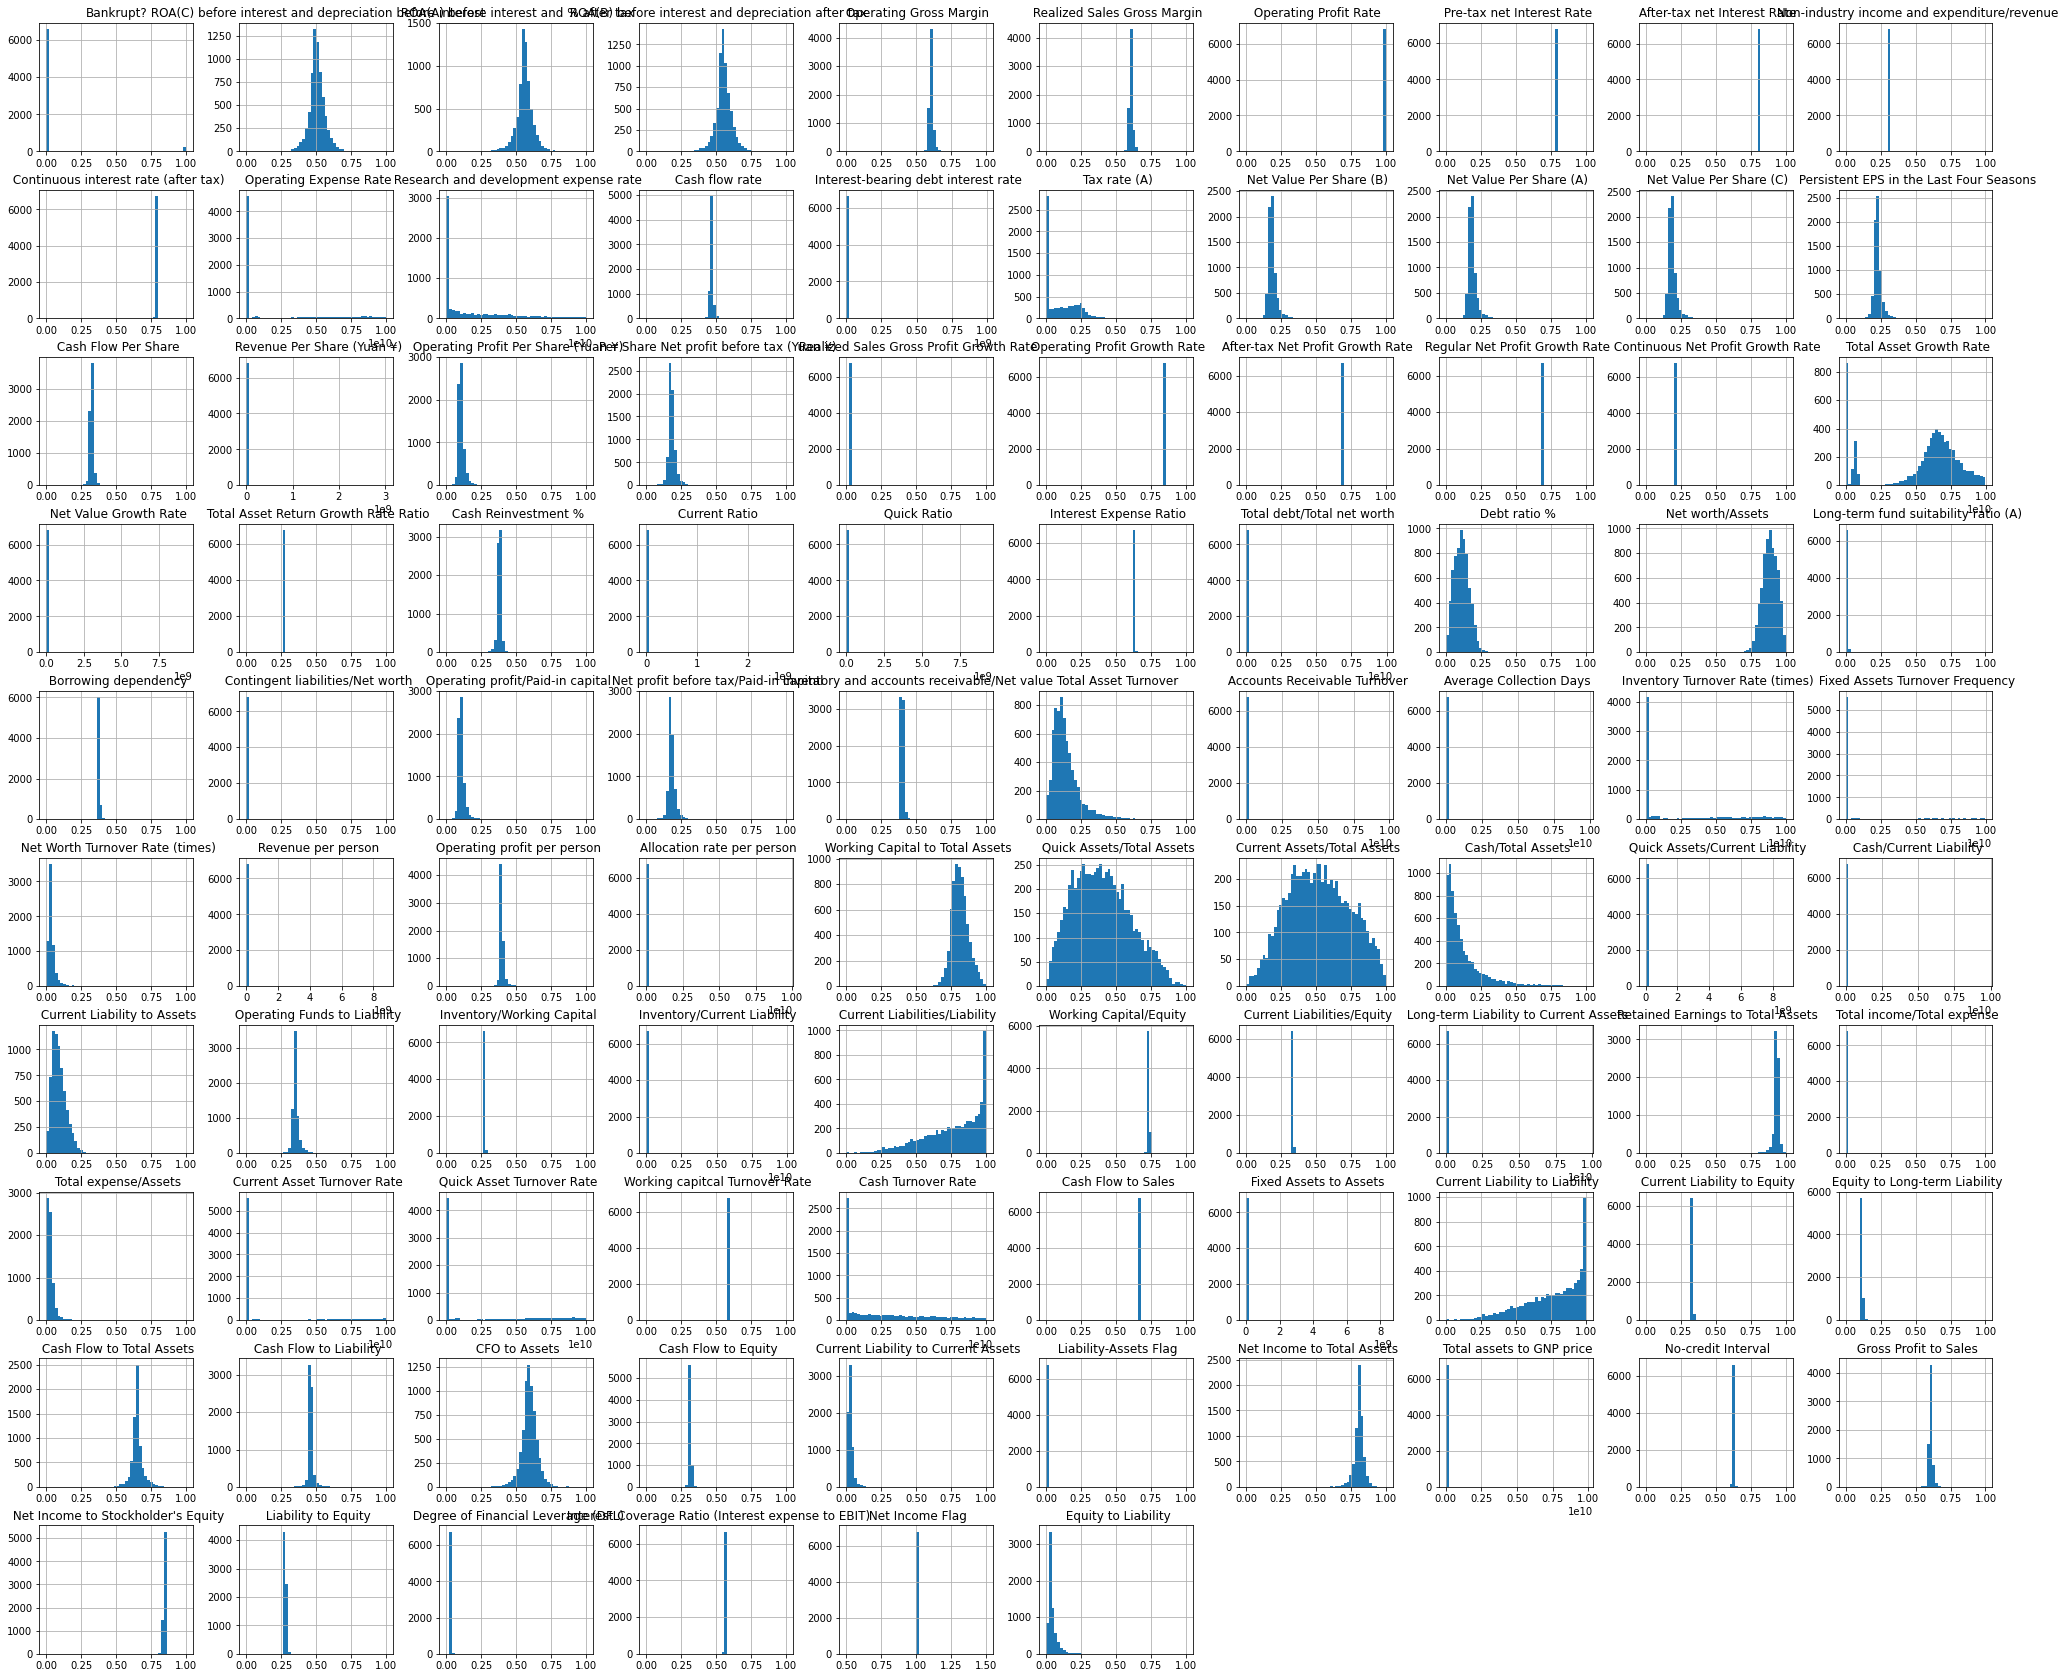

In [8]:
# Exploratory Data Analysis (EDA)
# Looking at the histograms of numerical data

dataset.hist(figsize = (35,30), bins = 50)
plt.show()

In [9]:
# try to remove the most extreme outliers
def outliers_removal(feature,feature_name,dataset):
    
    # Identify 25th & 75th quartiles

    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
    feat_iqr = q75 - q25
    print('iqr: {}'.format(feat_iqr))
    
    feat_cut_off = feat_iqr * 1.5
    feat_lower, feat_upper = q25 - feat_cut_off, q75 + feat_cut_off
    print('Cut Off: {}'.format(feat_cut_off))
    print(feature_name +' Lower: {}'.format(feat_lower))
    print(feature_name +' Upper: {}'.format(feat_upper))
    
    outliers = [x for x in feature if x < feat_lower or x > feat_upper]
    print(feature_name + ' outliers for close to bankruptcy cases: {}'.format(len(outliers)))
    #print(feature_name + ' outliers:{}'.format(outliers))

    dataset = dataset.drop(dataset[(dataset[feature_name] > feat_upper) | (dataset[feature_name] < feat_lower)].index)
    print('-' * 65)
    
    return dataset

for col in dataset:
    new_df = outliers_removal(dataset[col],str(col),dataset)

Quartile 25: 0.0 | Quartile 75: 0.0
iqr: 0.0
Cut Off: 0.0
Bankrupt? Lower: 0.0
Bankrupt? Upper: 0.0
Bankrupt? outliers for close to bankruptcy cases: 220
-----------------------------------------------------------------
Quartile 25: 0.47652708038804703 | Quartile 75: 0.535562813825379
iqr: 0.05903573343733193
Cut Off: 0.08855360015599789
 ROA(C) before interest and depreciation before interest Lower: 0.38797348023204914
 ROA(C) before interest and depreciation before interest Upper: 0.6241164139813768
 ROA(C) before interest and depreciation before interest outliers for close to bankruptcy cases: 391
-----------------------------------------------------------------
Quartile 25: 0.53554295682512 | Quartile 75: 0.58915721761884
iqr: 0.05361426079372
Cut Off: 0.08042139119058
 ROA(A) before interest and % after tax Lower: 0.45512156563454
 ROA(A) before interest and % after tax Upper: 0.66957860880942
 ROA(A) before interest and % after tax outliers for close to bankruptcy cases: 561
----

In [10]:
# Dividing Data and Labels

labels = new_df['Bankrupt?']
new_df = new_df.drop(['Bankrupt?'], axis = 1)

In [11]:
def log_trans(data):
    
    for col in data:
        skew = data[col].skew()
        if skew > 0.5 or skew < -0.5:
            data[col] = np.log1p(data[col])
        else:
            continue
            
    return data

data_norm = log_trans(new_df)

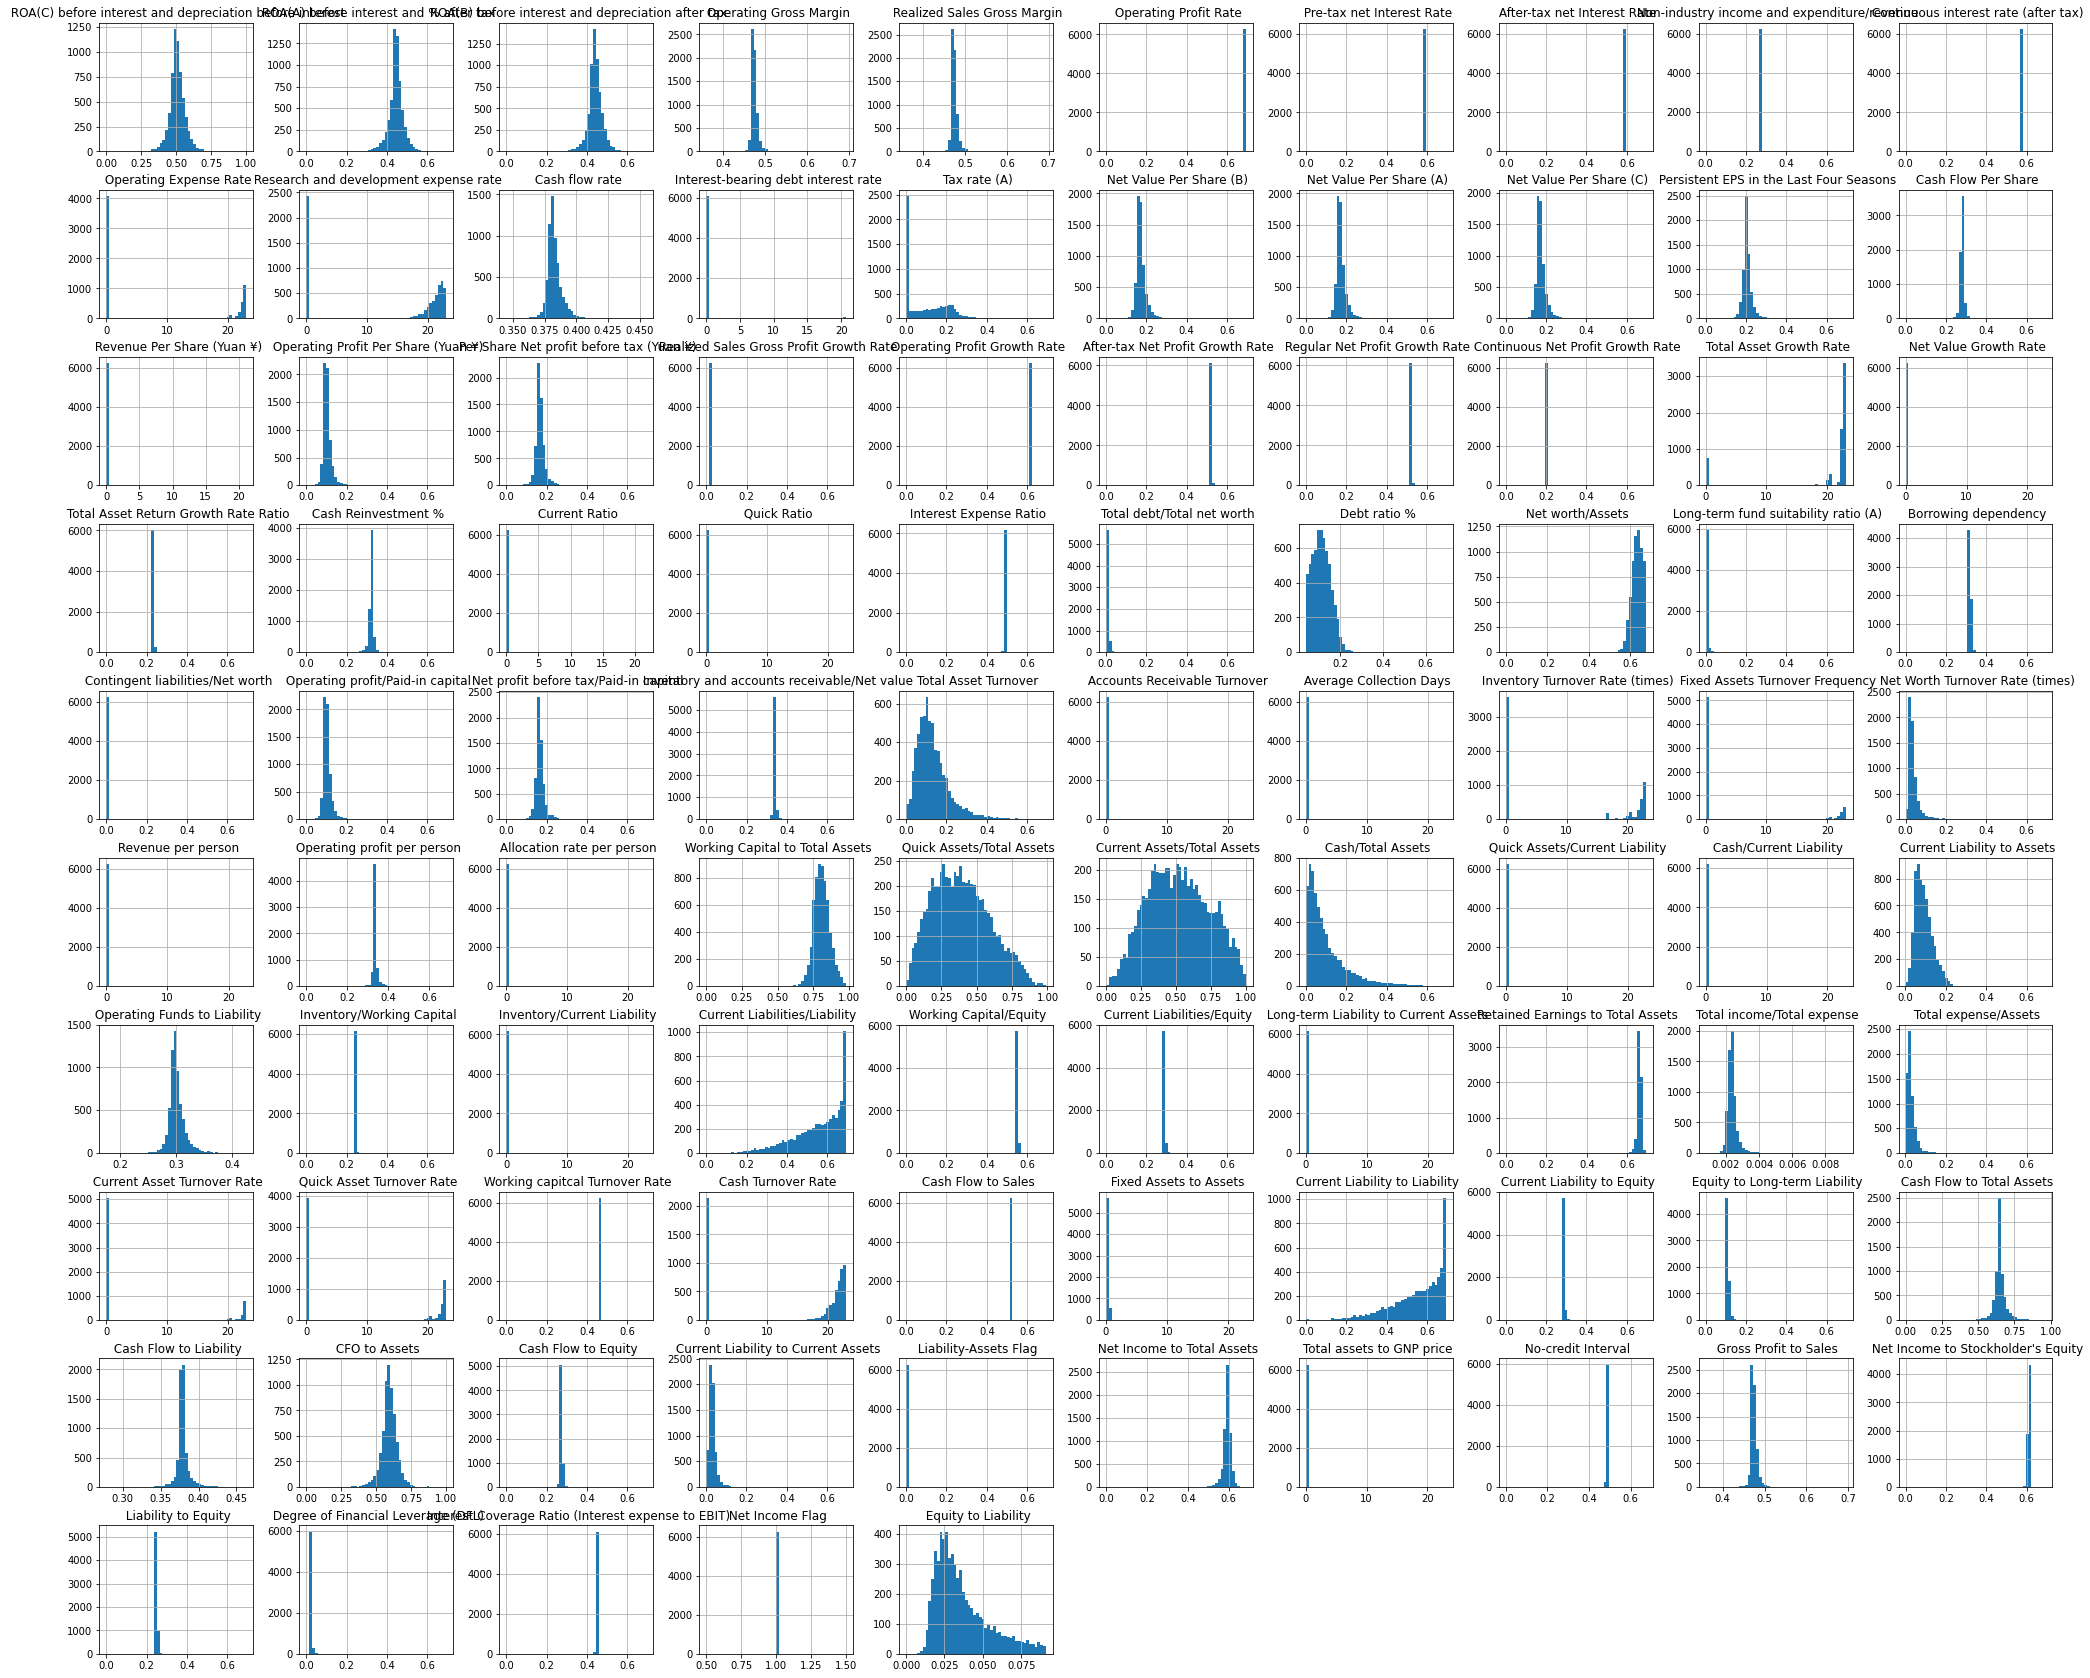

In [12]:
data_norm.hist(figsize = (35,30),bins = 50)
plt.show()

In [13]:
# Splitting Train and Test Data

X_raw,X_test,y_raw,y_test  = train_test_split(data_norm,
                                              labels,
                                              test_size=0.2,
                                              stratify = labels,
                                              random_state = 42)

In [14]:
# Stratified Cross Validation Splitting

sss = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)

for train_index, test_index in sss.split(X_raw,y_raw):
    
    print("Train:", train_index, "Test:", test_index)
    X_train_sm, X_val_sm = X_raw.iloc[train_index], X_raw.iloc[test_index]
    y_train_sm, y_val_sm = y_raw.iloc[train_index], y_raw.iloc[test_index]

# Check the Distribution of the labels


# Turn into an array
X_train_sm = X_train_sm.values
X_val_sm = X_val_sm.values
y_train_sm = y_train_sm.values
y_val_sm = y_val_sm.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(y_train_sm, return_counts=True)
test_unique_label, test_counts_label = np.unique(y_val_sm, return_counts=True)
print('-' * 84)

print('Label Distributions: \n')
print(train_counts_label/ len(y_train_sm))
print(test_counts_label/ len(y_val_sm))

Train: [ 998  999 1000 ... 5013 5014 5015] Test: [   0    1    2 ... 1093 1144 1150]
Train: [   0    1    2 ... 5013 5014 5015] Test: [ 998  999 1000 ... 2004 2006 2044]
Train: [   0    1    2 ... 5013 5014 5015] Test: [2005 2007 2008 ... 3011 3012 3013]
Train: [   0    1    2 ... 5013 5014 5015] Test: [2971 2983 2984 ... 4014 4015 4016]
Train: [   0    1    2 ... 4014 4015 4016] Test: [3915 3975 3981 ... 5013 5014 5015]
------------------------------------------------------------------------------------
Label Distributions: 

[0.96536257 0.03463743]
[0.96510469 0.03489531]


In [15]:
# CATBOOST
# List to append the score and then find the average

accuracy_lst_cat = []
precision_lst_cat = []
recall_lst_cat = []
f1_lst_cat = []
auc_lst_cat = []

cat_sm = CatBoostClassifier(verbose = 0)

cat_params = {'eval_metric': ['F1'],
              'iterations': [100,500,1000],
              'learning_rate' : [0.1,0.01,0.001],
              'random_seed' : [42],
              'auto_class_weights' : ['Balanced','SqrtBalanced']
             }
    
    
rand_cat = RandomizedSearchCV(cat_sm, cat_params, n_iter=4)


for train, val in sss.split(X_train_sm, y_train_sm):
    pipeline_cat = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_cat) # SMOTE happens during Cross Validation not before..
    model_cat = pipeline_cat.fit(X_train_sm, y_train_sm)
    best_est_cat = rand_cat.best_estimator_
    prediction_cat = best_est_cat.predict(X_train_sm[val])
    
    accuracy_lst_cat.append(pipeline_cat.score(X_train_sm[val], y_train_sm[val]))
    precision_lst_cat.append(precision_score(y_train_sm[val], prediction_cat))
    recall_lst_cat.append(recall_score(y_train_sm[val], prediction_cat))
    f1_lst_cat.append(f1_score(y_train_sm[val], prediction_cat))
    auc_lst_cat.append(roc_auc_score(y_train_sm[val], prediction_cat))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst_cat)))
print("precision: {}".format(np.mean(precision_lst_cat)))
print("recall: {}".format(np.mean(recall_lst_cat)))
print("f1: {}".format(np.mean(f1_lst_cat)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 1.0
precision: 1.0
recall: 1.0
f1: 1.0
---------------------------------------------------------------------------------------------------------------------------------------


In [16]:
smote_prediction_cat = best_est_cat.predict(X_val_sm)
print(classification_report(y_val_sm, smote_prediction_cat))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       968
           1       0.55      0.49      0.52        35

    accuracy                           0.97      1003
   macro avg       0.76      0.74      0.75      1003
weighted avg       0.97      0.97      0.97      1003



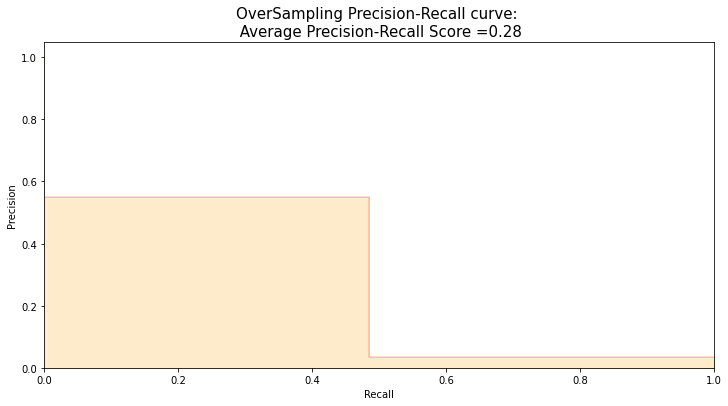

In [17]:
# Plotting Precision-Recall curve

smote_prediction_cat = best_est_cat.predict(X_val_sm)

average_precision_cat = average_precision_score(y_val_sm, smote_prediction_cat)

fig = plt.figure(figsize=(12,6))

precision_cat, recall_cat, _ = precision_recall_curve(y_val_sm, smote_prediction_cat)

plt.step(recall_cat, precision_cat, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall_cat, precision_cat, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision_cat), fontsize=15)

plt.show()

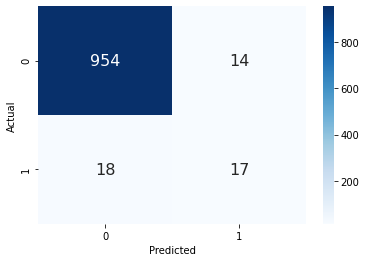

In [18]:
# Plotting confusion matrix
conf_mx = confusion_matrix(y_val_sm,smote_prediction_cat)
heat_cm = pd.DataFrame(conf_mx, columns=np.unique(y_val_sm), index = np.unique(y_val_sm))
heat_cm.index.name = 'Actual'
heat_cm.columns.name = 'Predicted'
sns.heatmap(heat_cm, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')

plt.show()

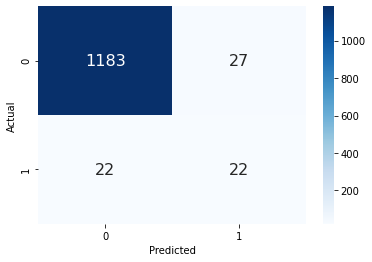

In [19]:
# Testing
test_pred_cat = best_est_cat.predict(X_test)
conf_mx1 = confusion_matrix(y_test,test_pred_cat)
heat_cm1 = pd.DataFrame(conf_mx1, columns=np.unique(y_test), index = np.unique(y_test))
heat_cm1.index.name = 'Actual'
heat_cm1.columns.name = 'Predicted'
sns.heatmap(heat_cm1, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g')

plt.show()

In [20]:
# ouput the result of catboost model prediction on test set
print(classification_report(y_test, test_pred_cat))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1210
           1       0.45      0.50      0.47        44

    accuracy                           0.96      1254
   macro avg       0.72      0.74      0.73      1254
weighted avg       0.96      0.96      0.96      1254

